<a href="https://colab.research.google.com/github/kburns/cism_dedalus_2023/blob/main/lecture_3_2d_turbulence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forcing & Analysis -- 2D Turbulence

**Overview:** This notebook describes how to construct a forced 2D turbulence simulation and analyze the output.

**About Dedalus:** [Dedalus](http://dedalus-project.org) is an open-source Python package for solving partial differential equations (PDEs) using global spectral methods.
These methods provide highly accurate numerical solutions for PDEs with smooth solutions in simple domains like boxes and spheres.
Dedalus implements modern parallel algorithms utilizing sparse polynomial bases, but all with an easy-to-use symbolic interface.
The code is being used in a wide range of fields, often for problems involving fluid dynamics.

**Author:** [Keaton Burns](http://keaton-burns.com)

# Setup

This cell checks if Dedalus is installed and performs some other basic setup.

If Dedalus is not installed and you are using Google Colab, it will automatically be installed.
This may take a few minutes the first time you run the notebook, but subsequent sessions during the next day or so should have the installation cached.
No need to worry about the details -- just execute the cell.

If you are not using Google Colab, follow the installation instructions in the [Dedalus Docs](https://dedalus-project.readthedocs.io/en/latest/pages/installation.html) to install Dedalus locally on your computer.
Installation using conda is typically straightforward for Mac and Linux.
No promises on Windows.
Execute the cell to confirm Dedalus is installed and importable.

In [1]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install --no-cache http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus already installed :)


# Content

First let's import everything we need to run the rest of the notebook.

In [2]:
import numpy as np
np.seterr(over="raise")
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)
%matplotlib widget

## 1. Setup domain and fields

We begin by setting up the domain for a forced 2D turbulence simulation.
We'll take as our domain a doubly-periodic box of size $L = 2 \pi$, discretized with $N$ Fourier modes in each dimension.

We first create a Cartesian coordinate system, then a Distributor object, and finally RealFourier bases for each dimension.
Since we'll be solving Navier-Stokes with quadratic nonlinearities, we'll pick the dealias factors to be 3/2.

In [3]:
# Domain parameters
L = 2 * np.pi
N = 512
mesh = None
dtype = np.float64
dealias = 3 / 2

# Domain
coords = d3.CartesianCoordinates('x', 'y')
dist = d3.Distributor(coords, mesh=mesh, dtype=dtype)
xbasis = d3.RealFourier(coords[0], N, bounds=(0, L), dealias=dealias)
ybasis = d3.RealFourier(coords[1], N, bounds=(0, L), dealias=dealias)

Next we create the fields we'll need for the simulation.
For incompressible 2D flow, we can use the streamfunction-vorticity formulation to simply the enforcement of incompressibility and speed up the computation.
This requires us to define just the streamfunction $\psi$ as the variable field we'll be solving for.
We also create a constant field $c$ which will be used to set the gauge freedom in the streamfunction-vorticity formulation.

In [4]:
# Fields
psi = dist.Field(name='psi', bases=(xbasis, ybasis))
c = dist.Field(name='c')

We do not need to define other fields to represent the velocity or vorticity.
These can be written entirely as symbolic expressions based on the streamfunction using the vector calculus operators in Dedalus, and used later to simplify the specification of equations and analysis tasks.

In [5]:
# Substitutions
u = -d3.skew(d3.grad(psi))  # velocity vector: [dy(psi), -dx(psi)]
w = -d3.lap(psi)            # vorticity: dx(uy) - dy(ux)
e = (u@u) / 2               # energy density
z = (w*w) / 2               # enstrophy density

## 2. Stochastic forcing

To get a statistically-steady turbulent state, we will use stochastic band-limited forcing with a prescribed energy injection rate.
First we specify the energy injection rate, primary wavenumber, and bandwidth of the stochastic forcing.
We then create a field called `Fw` whose values will be set to a new random forcing on every iteration, and define functions to do so.

The precise normalizations of forcings like this are tricky to get right, but important for precisely controlling the rate of energy injection.
Here we create a normalized Gaussian random field with support concentrated on a ring in Fourier space.
We also create a function that scales this forcing according to the timestep, as required for a stochastic integrator, and sets the coefficients of the `Fw` field.

In [6]:
# Forcing parameters
epsilon = 1     # Energy injection rate
kf = 50         # Forcing wavenumber
kfw = 2         # Forcing bandwidth
seed = None     # Random seed

# Derived parameters
eta = epsilon * kf**2  # Enstrophy injection rate

# Forcing field and derived parameters
Fw = dist.Field(name='Fw', bases=(xbasis, ybasis))
kx = xbasis.wavenumbers[dist.local_modes(xbasis)]
ky = ybasis.wavenumbers[dist.local_modes(ybasis)]
dkx = dky = 2 * np.pi / L

# Forcing function
rand = np.random.RandomState(seed)

def draw_gaussian_random_field():
    """Create Gaussian random field concentrating on a ring in Fourier space with unit variance."""
    k = (kx**2 + ky**2)**0.5
    # 1D power spectrum: normalized Gaussian, no mean
    P1 = np.exp(-(k-kf)**2/2/kfw**2) / np.sqrt(kfw**2 * np.pi / 2) * (k != 0)
    # 2D power spectrum: divide by polar Jacobian
    P2 = P1 / 2 / np.pi / (k + (k==0))
    # 2D coefficient poewr spectrum: divide by mode power
    Pc = P2 / 2**((kx == 0).astype(float) + (ky == 0).astype(float) - 2)
    # Forcing amplitude, including division between sine and cosine
    f_amp = (Pc / 2 * dkx * dkx)**0.5
    # Forcing with random phase
    f = f_amp * rand.randn(*k.shape)
    return f

def set_vorticity_forcing(timestep):
    """Set vorticity forcing field from scaled Gaussian random field."""
    # Set forcing to normalized Gaussian random field
    Fw['c'] = draw_gaussian_random_field()
    # Rescale by forcing rate, including factor for 1/2 in kinetic energy
    Fw['c'] *= (2 * eta / timestep)**0.5

## 3. Build problem and solver

Next we can build the Problem and Solver objects for our simulation.
Our PDE is 2D incompressible Navier-Stokes in the streamfunction-vorticity formulation.
We will include large-scale drag as well, so the simulation can come into energy equilibrium:

$$\partial_t \omega + \vec{u} \cdot \nabla \omega = - \alpha \omega + \nu \nabla^2 \omega + F_\omega$$
$$\omega = - \nabla^2 \psi$$

Since we have symbolically defined $\omega$ in terms of $\psi$ via the Laplacian, we do not need this as an additional equation.
However, in this formulation there is a gauge freedom in the mean value of the streamfunction.
This gauge must be fixed to create a well-posed problem.
This is achieved by adding our undetermined constant field $c$ to the vorticity equaion, effectively absorbing the mean mode of the vorticity equation which otherwise reads $0 = 0$.
This gives us the freedom to add an additional constraint fixing the streamfunction gauge.

In [7]:
# Problem parameters
L_diss = L / N  # Dissipation scale
L_fric = L      # Friction scale

# Derived parameters
nu = L_diss**2 * eta**(1/3)                 # Viscosity
alpha = epsilon**(1/3) * L_fric**(-2/3)     # Friction

# Problem
problem = d3.IVP([psi, c], namespace=locals())
problem.add_equation("dt(w) - nu*lap(w) + alpha*w + c = -u@grad(w) + Fw")
problem.add_equation("integ(psi) = 0");

Running multidimensional simulations on a single core in a notebook is rather slow, so we'll just run this simulation for a very short time for illustrative purposes.
The full script associated with this example is also available in the [online repository](https://github.com/kburns/cism_dedalus_2023), and this version can be easily ran at larger scale on a workstation or cluster.

In [8]:
# Solver parameters
timestepper = d3.RK443
stop_sim_time = 0.5

# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

2023-04-17 08:39:50,570 subsystems 0/1 INFO :: Building subproblem matrices 1/256 (~0%) Elapsed: 0s, Remaining: 11s, Rate: 2.3e+01/s
2023-04-17 08:39:51,030 subsystems 0/1 INFO :: Building subproblem matrices 26/256 (~10%) Elapsed: 1s, Remaining: 4s, Rate: 5.2e+01/s
2023-04-17 08:39:51,541 subsystems 0/1 INFO :: Building subproblem matrices 52/256 (~20%) Elapsed: 1s, Remaining: 4s, Rate: 5.1e+01/s
2023-04-17 08:39:52,040 subsystems 0/1 INFO :: Building subproblem matrices 78/256 (~30%) Elapsed: 2s, Remaining: 3s, Rate: 5.2e+01/s
2023-04-17 08:39:52,536 subsystems 0/1 INFO :: Building subproblem matrices 104/256 (~41%) Elapsed: 2s, Remaining: 3s, Rate: 5.2e+01/s
2023-04-17 08:39:53,033 subsystems 0/1 INFO :: Building subproblem matrices 130/256 (~51%) Elapsed: 3s, Remaining: 2s, Rate: 5.2e+01/s
2023-04-17 08:39:53,526 subsystems 0/1 INFO :: Building subproblem matrices 156/256 (~61%) Elapsed: 3s, Remaining: 2s, Rate: 5.2e+01/s
2023-04-17 08:39:54,034 subsystems 0/1 INFO :: Building subp

## 4. Analysis tasks

To simplify saving simulation data, Dedalus includes a framework for evaluating and saving arbitrary analysis tasks while an initial value problem is running.
These analysis tasks can be specified symbolically and are saved to HDF5 files.

**Analysis handlers**

The explicit evaluation of analysis tasks during timestepping is controlled by the `solver.evaluator` object.
Various handler objects can be attached to the evaluator, and control when the evaluator computes their own set of tasks and what happens to the resulting data.
For simulation analysis, the most useful handler is the `FileHandler`, which regularly computes tasks and writes the data to HDF5 files. 

When setting up a file handler, you specify the name/path for the output directory/files, as well as the cadence at which you want the handler's tasks to be evaluated.
This cadence can be in terms of any combination of:
* simulation time, specified with `sim_dt`,
* wall time, specified with `wall_dt`
* iteration number, specified with `iter`

To limit file sizes, the output from a file handler is split up into different "sets" over time, each containing some number of writes that can be limited with the `max_writes` keyword when the file handler is constructed.
You can add an arbitrary number of file handlers to save different sets of tasks at different cadences and to different files.

**Analysis tasks**



Analysis tasks are added to a given handler using the `add_task` method. 
Tasks are entered as operator expressions or in plain text and parsed using the same namespace that is used for equation entry. 
For each task, you can additionally specify the output layout, scaling factors, and a referece name.

Let's create two different handlers, one for saving simulation snapshots, and one for saving scalar summary statistics at a higher cadence:

In [9]:
# Analysis parameters
snapshots_dt = 0.1
scalars_dt = 0.01

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=snapshots_dt, max_writes=10, mode='overwrite')
snapshots.add_task(psi, name='psi')
snapshots.add_task(w, name='vorticity')

scalars = solver.evaluator.add_file_handler('scalars', sim_dt=scalars_dt, max_writes=100, mode='overwrite')
ave = d3.Average
scalars.add_task(ave(e), name='E')
scalars.add_task(ave(z), name='Z')
scalars.add_task(ave(-alpha * 2 * e), name='E friction')
scalars.add_task(ave(-alpha * 2 * z), name='Z friction')
scalars.add_task(ave(nu * u @ d3.lap(u)), name='E viscosity')
scalars.add_task(ave(nu * w * d3.lap(w)), name='Z viscosity')

## 5. Adaptive timestepping and main loop

For more complex simulations, a constant timestep may be too restrictive, and we may want to choose the timestep adaptively based on a CFL criterion.
The Dedalus `CFL` tool allows you to do this, and has a number of optional parameters to prevent unneccesary timestep changes (which can be computationally costly) and to keep the timestep within reasonable bounds.

Here's an example of setting up a CFL criterion based on an estimate of the RMS velocity we expect, and some typical parameters choices for the CFL options:

In [10]:
# Timestepping parameters
dx = L / N                          # Grid spacing
U = epsilon**(1/3) * L_fric**(1/3)  # Friction velocity
safety = 0.5                        # CFL safety factor
max_dt = safety * dx / U            # Timestep

# CFL
CFL = d3.CFL(solver, initial_dt=max_dt, cadence=10, safety=safety, max_change=1.5, min_change=0.5, max_dt=max_dt, threshold=0.05)
CFL.add_velocity(u)

We can now run the simulation just as in the previous tutorial, but without needing to manually save any data during the main loop. 
The evaluator will automatically compute and save the specified analysis tasks at the proper cadence as the simulation is advanced.
First, we compute the new timestep every iteration using the `CFL.compute_timestep` method.
We then set new random forcing and take a step forward using this timestep.
At the end of the simulation, we can print some common run statistics with `solver.log_stats()`.

In [11]:
# Main loop
try:
    logger.info('Starting loop')
    while solver.proceed:
        timestep = CFL.compute_timestep()
        set_vorticity_forcing(timestep)
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

2023-04-17 08:39:55,730 __main__ 0/1 INFO :: Starting loop
2023-04-17 08:39:58,994 __main__ 0/1 INFO :: Iteration=1, Time=3.325217e-03, dt=3.325217e-03
2023-04-17 08:40:02,944 __main__ 0/1 INFO :: Iteration=11, Time=3.657738e-02, dt=3.325217e-03
2023-04-17 08:40:06,747 __main__ 0/1 INFO :: Iteration=21, Time=6.982955e-02, dt=3.325217e-03
2023-04-17 08:40:10,537 __main__ 0/1 INFO :: Iteration=31, Time=1.030817e-01, dt=3.325217e-03
2023-04-17 08:40:14,517 __main__ 0/1 INFO :: Iteration=41, Time=1.363339e-01, dt=3.325217e-03
2023-04-17 08:40:18,320 __main__ 0/1 INFO :: Iteration=51, Time=1.695861e-01, dt=3.325217e-03
2023-04-17 08:40:22,189 __main__ 0/1 INFO :: Iteration=61, Time=2.028382e-01, dt=3.325217e-03
2023-04-17 08:40:26,622 __main__ 0/1 INFO :: Iteration=71, Time=2.330550e-01, dt=3.021676e-03
2023-04-17 08:40:30,468 __main__ 0/1 INFO :: Iteration=81, Time=2.632717e-01, dt=3.021676e-03
2023-04-17 08:40:34,861 __main__ 0/1 INFO :: Iteration=91, Time=2.961352e-01, dt=3.286348e-03
20

## 6. Post-processing

By default, the output files for each file handler are arranged as follows:

1. A base folder taking the name that was specified when the file handler was constructed, e.g. `scalars/`.
2. Within the base folder are HDF5 files for each output set, with the same name plus a set number, e.g. `scalars_s1.h5`.

Each HDF5 file contains a "tasks" group containing a dataset for each task assigned to the file handler. 
The first dimension of the dataset is time, the subsequent dimensions are the vector/tensor components of the task (if applicable), and finally the spatial dimensions of the task.

The HDF5 datasets are self-describing, with dimensional scales attached to each axis. 
For the first axis, these include the simulation time, wall time, iteration, and write number. 
For the spatial axes, the scales correspond to grid points or modes, based on the task layout.

Let's open up the first scalars set file and plot a time series of the average kinetic energy:

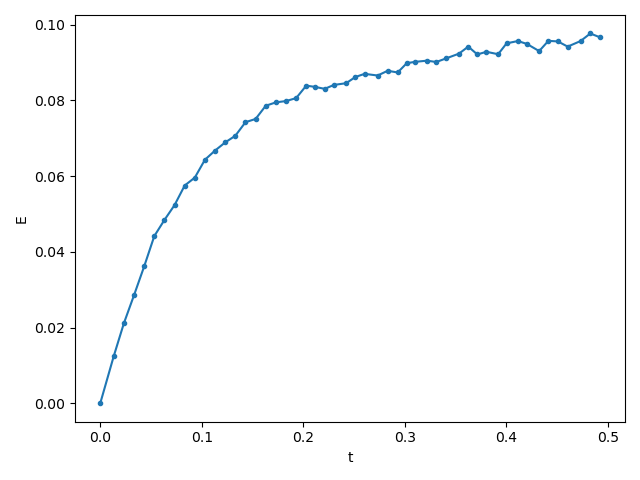

In [12]:
import h5py

# Load energy and enstrophy traces
scalars = h5py.File('scalars/scalars_s1.h5', mode='r')
E = scalars['tasks']['E'][:]
Z = scalars['tasks']['Z'][:]
t = scalars['tasks']['E'].dims[0]['sim_time'][:]

# Plot data
plt.figure()
plt.plot(t, E.ravel(), '.-')
plt.xlabel('t')
plt.ylabel('E')
plt.tight_layout()


And let's plot the final vorticity snapshot:

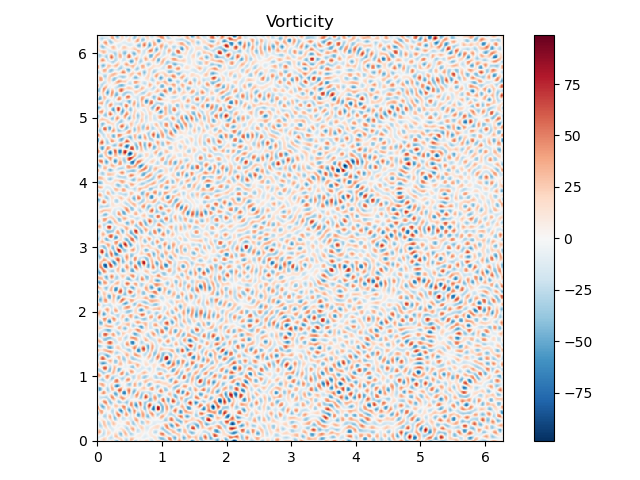

In [13]:
# Load energy and enstrophy traces
snapshots = h5py.File('snapshots/snapshots_s1.h5', mode='r')
psi = snapshots['tasks']['psi'][:]
w = snapshots['tasks']['vorticity'][:]
x = snapshots['tasks']['vorticity'].dims[1]['x'][:]
y = snapshots['tasks']['vorticity'].dims[2]['y'][:]

# Plot data
clim = np.max(np.abs(w[-1]))
plt.figure()
plt.pcolormesh(x, y, w[-1], cmap='RdBu_r', clim=(-clim, clim))
plt.axis('scaled')
plt.colorbar()
plt.title('Vorticity')
plt.tight_layout()


Finally let's plot the power spectrum of the solution. 
This can be done by directly saving coefficient-space data from Dedalus (pass `layout='c'` in the `add_task` method), or simply by using numpy FFTs to change our grid-space data to complex coefficients.
Let's do that here. Again be careful of normalizations if you want to get the amplitude right -- numpy FFTs and Dedalus FFTs are normalized differently.

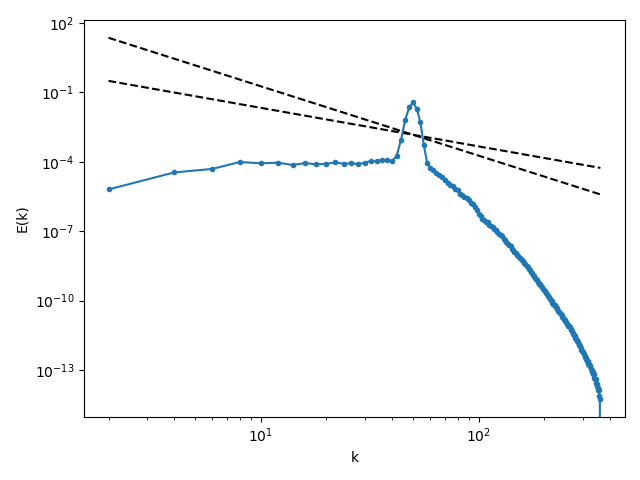

In [14]:
# Setup frequency bins
kx = np.fft.fftfreq(N, 1/N)[:, None]
ky = np.fft.fftfreq(N, 1/N)[None, :]
k = (kx**2 + ky**2)**0.5
kmax = int(np.ceil(np.max(k)))
bins = np.arange(1, kmax+1, 2)
kcen = bins[:-1] + np.diff(bins)/2

# Use renormalized numpy FFT to compute power spectrum
E_k2 = np.abs(np.fft.fft2(psi[-1])/N**2)**2 * k**2
E_k1 = E_k2 * 2 * np.pi * k

# Build histogram over modes, weighted by energy
pow_samples, _ = np.histogram(k, bins=bins, weights=E_k1)
hist_samples, _ = np.histogram(k, bins=bins)
spectrum = pow_samples / hist_samples

# Plot histogram
plt.figure()
plt.loglog(kcen, epsilon**(2/3)*kcen**(-5/3), '--k')
plt.loglog(kcen, eta**(2/3)*kcen**(-3), '--k')
plt.loglog(kcen, spectrum, '.-')
plt.xlabel("k")
plt.ylabel("E(k)")
plt.tight_layout()

This simulation isn't very high Reynold's number and didn't run very long, since we're only using a single core in the notebook.
The same simulation script, however, can be run directly on a workstation or cluster with higher $N$ and more processes to produce a more turbulent simulation.
I've done this offline, and included the saved data here in the `turbulence_data_4096` folder.
Try making these same plots using this data.